In [4]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

%matplotlib inline


def byte_decoder(val):
    # decodes byte literals to strings
    
    return val.decode('utf-8')

def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Blues):
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def time(expr):
    start = datetime.datetime.now()
    code = eval(expr)
    end = datetime.datetime.now()
    return (end-start, code)

sa_columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment",
                           "urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted",
                           "num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login",
                           "is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
                           "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
                           "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
                           "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
                           "dst_host_rerror_rate","dst_host_srv_rerror_rate"]
sf_columns = ["duration", "service", "src_bytes", "dst_bytes"]

# GridsearchCV Isolation Forest

In [3]:
sf = datasets.fetch_kddcup99(subset='SF',percent10 = False, random_state=0)
dfsf = pd.DataFrame(sf.data, columns=sf_columns)
dfsf["target"]=sf.target
anomaly_rate_sf = 1.0 - len(dfsf.loc[dfsf["target"]==b'normal.'])/len(dfsf)
print(f"SF anomaly rate is {anomaly_rate_sf:.1%}")

dfsf['binary_target'] = [1 if x==b'normal.' else -1 for x in dfsf["target"]]
toDecodeSF = ["service", "target"]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSF:
    dfsf[f] = list(map(byte_decoder, dfsf[f]))
    dfsf[f] = leSF.fit_transform(dfsf[f])

X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.33, random_state=0)

SF anomaly rate is 0.5%


In [4]:
parameters = {'contamination':[0.05, 0.1, 0.15, 0.2, 0.25]}
samples = {'max_samples': [0.1, 0.15, 0.20, 0.25]}

scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}

If = GridSearchCV(IsolationForest(behaviour='new', random_state=75, max_samples=0.25, n_jobs=-1, n_estimators=100), param_grid = parameters, scoring = scoring, refit="Recall")
If.fit(X_train_sf, y_train_sf)
If.best_params_

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'contamination': 0.15}

In [6]:
If_max_samples = GridSearchCV(IsolationForest(behaviour='new', random_state=75,contamination=If.best_params_['contamination'], n_jobs=-1, n_estimators=100), param_grid = samples, scoring = scoring, refit="Recall")
If_max_samples.fit(X_train_sf, y_train_sf)
If_max_samples.best_params_

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'max_samples': 0.1}

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


trainning done in 0:00:35.630327
              precision    recall  f1-score   support

      oulier       0.03      1.00      0.06      1101
      inlier       1.00      0.85      0.92    230912

   micro avg       0.85      0.85      0.85    232013
   macro avg       0.52      0.93      0.49    232013
weighted avg       1.00      0.85      0.92    232013

AUC: 92.7%


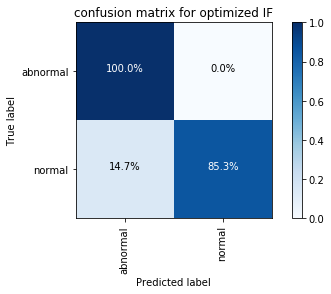

In [7]:
oIf = IsolationForest(random_state=1, n_jobs=-1, contamination=If.best_params_['contamination'], max_samples=If_max_samples.best_params_['max_samples'], n_estimators=100)
start = datetime.datetime.now()
y_pred = oIf.fit(X_train_sf).predict(X_test_sf)
fit_time = datetime.datetime.now() - start
print(f"trainning done in {fit_time}")
print(classification_report(y_test_sf, y_pred, target_names=['oulier', 'inlier']))
print(f"AUC: {roc_auc_score(y_test_sf, y_pred):.1%}")
cm = confusion_matrix(y_test_sf, y_pred)
plot_confusion_matrix(cm, "confusion matrix for optimized IF")

In [5]:
sf10p = datasets.fetch_kddcup99(subset='SF', random_state=0, percent10=True)
dfsf10p = pd.DataFrame(sf10p.data, columns=sf_columns)
dfsf10p["target"]=sf10p.target
anomaly_rate_sf = 1.0 - len(dfsf10p.loc[dfsf10p["target"]==b'normal.'])/len(dfsf10p)
f"SF anomaly rate is {anomaly_rate_sf:.1%}"

dfsf10p['binary_target'] = [1 if x==b'normal.' else -1 for x in dfsf10p["target"]]
toDecodeSF = ["service", "target"]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSF:
    dfsf10p[f] = list(map(byte_decoder, dfsf10p[f]))
    dfsf10p[f] = leSF.fit_transform(dfsf10p[f])

X_train_sf10p, X_test_sf10p, y_train_sf10p, y_test_sf10p = train_test_split(dfsf10p.drop(["target", 'binary_target'], axis=1), dfsf10p['binary_target'], test_size=0.25, random_state=0)

In [8]:
parameters = {'contamination':[0.05, 0.1, 0.15, 0.2, 0.25]}
scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}
samples = {'max_samples': [0.1, 0.15, 0.20, 0.25]}


If10p = GridSearchCV(IsolationForest(random_state=1, n_jobs=-1, behaviour="new", max_samples=0.25, n_estimators=100), param_grid = parameters, scoring = scoring, refit="Recall")
If10p.fit(X_train_sf10p, y_train_sf10p)
If10p.best_params_

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'contamination': 0.2}

In [9]:
If_max_samples10p = GridSearchCV(IsolationForest(behaviour='new', random_state=75,contamination=If10p.best_params_['contamination'], n_jobs=-1, n_estimators=100), param_grid = samples, scoring = scoring, refit="Recall")
If_max_samples10p.fit(X_train_sf, y_train_sf)
If_max_samples10p.best_params_

NameError: name 'X_train_sf' is not defined

In [ ]:
oIf10p = IsolationForest(random_state=1, n_jobs=-1, behaviour="new", contamination=If10p.best_params_['contamination'], max_samples=If_max_samples10p.best_params_['max_samples'], n_estimators=100)
start = datetime.datetime.now()
y_pred10p = oIf10p.fit(X_train_sf).predict(X_test_sf)
fit_time = datetime.datetime.now() - start
print(f"trainning done in {fit_time}")
print(f"AUC: {roc_auc_score(y_test_sf10p, y_pred10p)}")
cm = confusion_matrix(y_test_sf10p, y_pred10p)
plot_confusion_matrix(cm, "confusion matrix for optimized IF")

In [ ]:
parameters = {'contamination':[0.1, 0.11, 0.12, 0.13, 0.14, 0.15]}

def custom_scorer(estimator, X, Y=y_train_sf):
    
scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1), 'Accuracy': 'accuracy'}

If = GridSearchCV(IsolationForest(behaviour='new', random_state=75, max_samples=0.1, n_jobs=-1, n_estimators=100), param_grid = parameters, scoring = scoring, refit="Accuracy")
If.fit(X_train_sf, y_train_sf)
If.best_params_